# ResNet Vanilla feature extractor

This notebook aims to train a classifier based on representations extracted from a pretrained resNet. The goal is to assess the performance of the classifier when no reweighting is done on the dataset. 

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import time
import os
import copy
import visdom
import pandas as pd

plt.ion()   # interactive mode

In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/ghayat/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [2]:
path_dr_f_d = '../Datasets/doctor_nurse/dr/fem_dr_dark_56/'
path_dr_f_l = '../Datasets/doctor_nurse/dr/fem_dr_light_256/'
path_dr_m_d = '../Datasets/doctor_nurse/dr/mal_dr_dark_62/'
path_dr_m_l = '../Datasets/doctor_nurse/dr/mal_dr_light_308/'

dr_f_d = os.listdir(path_dr_f_d)
dr_f_l = os.listdir(path_dr_f_l)
dr_m_d = os.listdir(path_dr_m_d)
dr_m_l = os.listdir(path_dr_m_l)

path_nur_f_d = '../Datasets/doctor_nurse/nurse/fem_nurse_dark_63/'
path_nur_f_l = '../Datasets/doctor_nurse/nurse/fem_nurse_light_252/'
path_nur_m_d = '../Datasets/doctor_nurse/nurse/mal_nurse_dark_76/'
path_nur_m_l = '../Datasets/doctor_nurse/nurse/mal_nurse_light_203/'

nur_f_d = os.listdir(path_nur_f_d)
nur_f_l = os.listdir(path_nur_f_l)
nur_m_d = os.listdir(path_nur_m_d)
nur_m_l = os.listdir(path_nur_m_l)

dr_m, dr_f = len(dr_m_d) + len(dr_m_l), len(dr_f_d) + len(dr_f_l)

w_protected = 4

In [3]:
path_bask_r_m = '../Datasets/doctor_nurse/dr/fem_dr_dark_56/'
path_bask_r_m = '../Datasets/doctor_nurse/dr/fem_dr_light_256/'
path_bask_y_f = '../Datasets/doctor_nurse/dr/mal_dr_dark_62/'
path_bask_y_f = '../Datasets/doctor_nurse/dr/mal_dr_light_308/'

bask_f_d = os.listdir(path_dr_f_d)
bask_f_l = os.listdir(path_dr_f_l)
bask_m_d = os.listdir(path_dr_m_d)
bask_m_l = os.listdir(path_dr_m_l)

path_nur_f_d = '../Datasets/doctor_nurse/nurse/fem_nurse_dark_63/'
path_nur_f_l = '../Datasets/doctor_nurse/nurse/fem_nurse_light_252/'
path_nur_m_d = '../Datasets/doctor_nurse/nurse/mal_nurse_dark_76/'
path_nur_m_l = '../Datasets/doctor_nurse/nurse/mal_nurse_light_203/'

nur_f_d = os.listdir(path_nur_f_d)
nur_f_l = os.listdir(path_nur_f_l)
nur_m_d = os.listdir(path_nur_m_d)
nur_m_l = os.listdir(path_nur_m_l)

dr_m, dr_f = len(dr_m_d) + len(dr_m_l), len(dr_f_d) + len(dr_f_l)

w_protected = 4

path_bask_r_f = '../Datasets/basket_volley/basket/basket_f_r/'
path_bask_y_f = '../Datasets/basket_volley/basket/basket_f_y/'
path_bask_r_m = '../Datasets/basket_volley/basket/basket_m_r/'
path_bask_y_m = '../Datasets/basket_volley/basket/basket_m_y/'

bask_r_f = os.listdir(path_bask_r_f)
bask_y_f = os.listdir(path_bask_y_f)
bask_r_m = os.listdir(path_bask_r_m)
bask_y_m = os.listdir(path_bask_y_m)

path_voll_r_f = '../Datasets/basket_volley/volley/volley_f_r/'
path_voll_y_f = '../Datasets/basket_volley/volley/volley_f_y/'
path_voll_r_m = '../Datasets/basket_volley/volley/volley_m_r/'
path_voll_y_m = '../Datasets/basket_volley/volley/volley_m_y/'

voll_r_f = os.listdir(path_voll_r_f)
voll_y_f = os.listdir(path_voll_y_f)
voll_r_m = os.listdir(path_voll_r_m)
voll_y_m = os.listdir(path_voll_y_m)

In [10]:
set(voll_r_f)

{'10325543_10203124596409746_1531839601598008135_n_848.jpg',
 '1200px-Kimberly_Hill_2016_28cropped29_849.jpg',
 '14Blueteamphoto_850.jpeg',
 '19VOLLEYBALL1-articleLarge_851.jpg',
 '5dfab8d6028f0.image_852.jpg',
 '5e20c62979b4b.image_853.jpg',
 '6f06a76a-c8c0-4242-9400-3e6617e48e8b-Celia_Cullen_4_854.jpg',
 'Etto-2018-New-Professional-Women-Volleyball-Jerseys-Uniforms-Sportwear-Suit-Female-Volleyball-Sleeveless-Training-Kits-HXB008.jpg_640x640q70_856.jpg',
 'celebrationutah__1567455942_855.jpg',
 'image0_858.jpeg',
 'image11_860.jpeg',
 'image12_861.jpeg',
 'image14_862.jpeg',
 'image15_863.jpeg',
 'image1_859.jpeg',
 'image2_864.jpeg',
 'image3_865.jpeg',
 'image6_866.jpeg',
 'image7_867.jpeg',
 'image_857.jpeg',
 'images0_868.jpg',
 'images107_870.jpg',
 'images108_871.jpg',
 'images10_869.jpg',
 'images113_872.jpg',
 'images124_874.jpg',
 'images12_873.jpg',
 'images130_875.jpg',
 'images131_876.jpg',
 'images134_877.jpg',
 'images139_878.jpg',
 'images142_880.jpg',
 'images149_881.j

###  Defining dataloaders

In [7]:
class my_ImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform, protected_group, w_protected):
        super().__init__(root, transform)
        self.protected_group = protected_group
        self.w_protected = w_protected
        
    def __getitem__(self, index: int):
        w = self.w_protected if self.samples[index][0].split("/")[-1] in self.protected_group else 1
        return super().__getitem__(index), w

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


BIAS = 0.8
data_dir = '../Datasets/basket_volley/train_test_split'
image_datasets = {x: my_ImageFolder(os.path.join(data_dir, f"train_{BIAS}" if x=="train" and BIAS else x), data_transforms[x], set(bask_y_m + bask_y_f + voll_r_m + voll_r_f), w_protected)
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

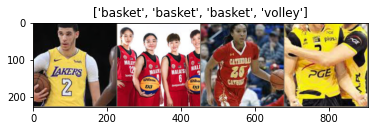

tensor([0, 0, 0, 1])
tensor([4, 1, 1, 1])


In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
(inputs, classes), weights = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print(classes)
print(weights)

## Training and evaluation of ResNet 

Note that to be able to visualize the training progress, you must have started a vsdom environment in a browser. The plots will show up there.

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, start_epoch=0, val_mode=False, show_progress=False, weighted=False):
    
    if show_progress:
        vis = visdom.Visdom()
        loss_window = vis.line(X=np.ones((1))*start_epoch,
                               Y=np.zeros((1, 2)) if val_mode else np.zeros((1)),
                               opts=dict(xlabel='epoch',
                                         ylabel='Loss',
                                         title='epoch loss',
                                         markers=True,
                                         legend=["Train", "Val"] if val_mode else ["Train"],
                                         ))   
        acc_window = vis.line(X=np.ones((1))*start_epoch,
                               Y=np.zeros((1, 2)) if val_mode else np.zeros((1)),
                               opts=dict(xlabel='epoch',
                                         ylabel='Accuracy',
                                         title='epoch accuracy',
                                         markers=True,
                                         legend=["Train", "Val"] if val_mode else ["Train"],
                                        ))  
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, start_epoch + num_epochs):
        losses, accuracies = {}, {}
        print('Epoch {}/{}'.format(epoch, start_epoch + num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        phases = ['train', 'val'] if val_mode else ["train"]
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for (inputs, labels), weights in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    if weighted:
                        loss = criterion(outputs, labels, weights)
                    else:
                        loss = criterion(outputs, labels)
                        
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase] = epoch_loss
            accuracies[phase] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
        if show_progress:
            X1 = np.ones((1))*epoch

            Y1 = np.array([losses["train"]])
            Y2 = np.array(losses["val"]) if val_mode else None
            vis.line(X=X1,Y=np.column_stack((Y1, Y2)) if val_mode else Y1,win=loss_window,update='append')

            Y1 = np.array([accuracies["train"]])
            Y2 = np.array([accuracies["val"]]) if val_mode else None
            vis.line(X=X1,Y=np.column_stack((Y1, Y2)) if val_mode else Y1, win=acc_window, update='append')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    if "val" in phases:
        model.load_state_dict(best_model_wts)
        
    return model

## Vizualize model

In [42]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, ((inputs, labels), weights) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, Actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Freezing all layers except last FC

#### Custom loss

In [29]:
def weighted_cross_entropy_loss(output, labels, weight):
    cel = -torch.log(torch.exp(output.gather(1, labels.view(-1,1))) / torch.sum(torch.exp(output), 1).view(-1,1))
    weighted_cel = weights * cel.view(-1)
    return torch.mean(weighted_cel)

For descirption of architecture of resNet, see: https://arxiv.org/pdf/1512.03385.pdf

In [33]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss() # weighted_cross_entropy_loss

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training

#### Loading checkpoint

In [31]:
VAL_MODE = False
WEIGHTED = False
w_protected = 4

In [29]:
EPOCH = 30
PATH =  ("Case_2/" if WEIGHTED else "Case_1/") + "checkpoints/" + ("w_val" if VAL_MODE else "w.o_val") + f"/Bias_{BIAS}/model_ep_{EPOCH}/checkpoint.pt"
checkpoint = torch.load(PATH)
model_conv.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
exp_lr_scheduler.load_state_dict(checkpoint["lr_scheduler_state_dict"])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


FileNotFoundError: [Errno 2] No such file or directory: 'Custom_loss/checkpoints/w.o_val/Bias_0.8/model_ep_30/checkpoint.pt'

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, start_epoch=0, num_epochs=30, val_mode=VAL_MODE, show_progress=False, weighted= WEIGHTED)

Epoch 0/29
----------
train Loss: 0.6389 Acc: 0.6932

Epoch 1/29
----------
train Loss: 0.4573 Acc: 0.7818

Epoch 2/29
----------
train Loss: 0.5328 Acc: 0.7843

Epoch 3/29
----------
train Loss: 0.4358 Acc: 0.8177

Epoch 4/29
----------
train Loss: 0.4878 Acc: 0.8190

Epoch 5/29
----------
train Loss: 0.4700 Acc: 0.8241

Epoch 6/29
----------
train Loss: 0.4253 Acc: 0.8177

Epoch 7/29
----------
train Loss: 0.4443 Acc: 0.8100

Epoch 8/29
----------
train Loss: 0.3339 Acc: 0.8691

Epoch 9/29
----------
train Loss: 0.3473 Acc: 0.8485

Epoch 10/29
----------
train Loss: 0.3432 Acc: 0.8434

Epoch 11/29
----------
train Loss: 0.3372 Acc: 0.8562

Epoch 12/29
----------
train Loss: 0.3403 Acc: 0.8460

Epoch 13/29
----------
train Loss: 0.3022 Acc: 0.8832

Epoch 14/29
----------
train Loss: 0.3182 Acc: 0.8614

Epoch 15/29
----------
train Loss: 0.2997 Acc: 0.8626

Epoch 16/29
----------
train Loss: 0.3163 Acc: 0.8537

Epoch 17/29
----------
train Loss: 0.3754 Acc: 0.8344

Epoch 18/29
--------

### Visualizing results 

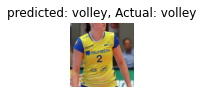

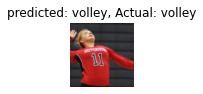

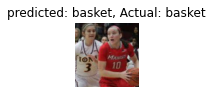

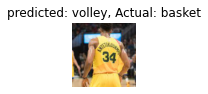

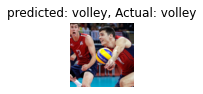

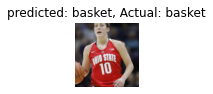

In [43]:
visualize_model(model_conv, dataloader=dataloaders["test"], num_images=6)

plt.ioff()
plt.show()

#### Saving checkpoint

In [43]:
EPOCH = 30
id = 20

PATH =  ("Case_2/" if WEIGHTED else "Case_1/") + "checkpoints/" + ("w_val" if VAL_MODE else "w.o_val") + f"/Bias_{BIAS}/model_ep_{EPOCH}/Run_{id}"
LOSS = "CrossEntropyLoss"

os.makedirs(PATH, exist_ok=True)
torch.save({
            'epoch': EPOCH,
            'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'lr_scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            'loss': LOSS,
            }, PATH + "/checkpoint.pt")

## Evaluate model

In [18]:
def accuracy(model, dataloader):
    model.eval() 
    corrects, total = 0, 0
    for i, ((inputs, labels), weights) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        corrects += torch.sum(preds == labels.data)
        total += inputs.size(0)
        
    print("Correct: ", corrects.int(), "total:", total)

    return corrects.double()/total

def demographic_parity(model, test_set):
    dr_path = os.path.join(test_set, "doctors") 
    nurs_path = os.path.join(test_set, "nurses") 
    
    dr_m_indices, dr_f_indices = split_gender(dr_path, dr_m_l + dr_m_d)
    nurs_m_indices, nurs_f_indices = split_gender(nurs_path, nur_m_d + nur_m_l)
    
    dr_m = torch.utils.data.Subset(image_datasets["test"], indices=dr_m_indices)
    dr_f = torch.utils.data.Subset(image_datasets["test"], indices=dr_f_indices)
    
    nurs_m = torch.utils.data.Subset(image_datasets["test"], indices=[len(dr_m + dr_f) + i for i in nurs_m_indices])
    nurs_f = torch.utils.data.Subset(image_datasets["test"], indices=[len(dr_m + dr_f) + i for i in nurs_f_indices])
    
    
    dataloaders = [torch.utils.data.DataLoader(x, batch_size=4, shuffle=True, num_workers=4) for x in [dr_m, dr_f, nurs_m, nurs_f]]  
    accuracies = [accuracy(model, dataloader) for dataloader in dataloaders]
    
    
    return pd.DataFrame(accuracies, index=["Doctor", "Nurse"], columns=["Men", "Women"])
    
       
def split_gender(path, male_group):
    s = os.listdir(path)
    
    l1, l2 = [], []
    for i, image in enumerate(s):
        if image in male_group:
            l1.append(i)
        else:
            l2.append(i)
            
    print(len(l1), len(l2), len(l1) + len(l2))
    return l1, l2